In [78]:
DEBUG = True
CONFIG_FILE = '/datascope/subaru/data/targeting/MW/outerdisk_l180_b25_ENG/netflow/outerdisk_l180_b25_faint_004/ga-netflow_20250123024132.config'
OUTPUT_PATH = '/datascope/subaru/data/targeting/MW/outerdisk_l180_b25_ENG/netflow/outerdisk_l180_b25_faint_004'

# Plot the instrument configuration

Given a netflow run, read back the config files and plot the instrument configuration. This currently consists of the cobra groups that set limits of how many sky fibers to allocate uniformly along the slits and how many flux standards to allocate evenly over the field of view.

In [79]:
import os, sys
from glob import glob
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [80]:
plt.rc('font', size=6)

In [81]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
if DEBUG and 'debug' not in globals():
    import debugpy
    debugpy.listen(('0.0.0.0', int(os.environ['PFS_TARGETING_DEBUGPORT'])))
    debug = True

# Imports

In [ ]:
import pfs.utils
from pfs.datamodel import TargetType

from pfs.ga.targeting.config.netflow import NetflowConfig
from pfs.ga.targeting.scripts.netflow.netflowscript import NetflowScript
from pfs.ga.targeting.io import DataFrameSerializer, ObservationSerializer
from pfs.ga.targeting.targets.dsph import *
from pfs.ga.targeting.instrument import *
from pfs.ga.targeting.diagram import CMD, CCD, FOV, FP, ColorAxis, MagnitudeAxis
from pfs.ga.targeting.photometry import Photometry, Magnitude, Color
from pfs.ga.targeting.projection import WcsProjection, Pointing
from pfs.ga.targeting.netflow import Netflow
from pfs.ga.targeting.io import DataFrameSerializer

# Load the netflow config file

In [84]:
# Load the configuration
config = NetflowConfig.default()
config.load(CONFIG_FILE, ignore_collisions=True, format='.json')

print(config.targets.keys())

2025-01-22T22:24:36.896 30 cobraCoach setting invisible cobras: [173, 648, 799, 853, 949, 1173, 1653, 1724, 2182]
2025-01-22T22:24:36.934 30 cobraCoach setting bad cobras: [47, 50, 173, 193, 344, 347, 361, 443, 493, 648, 738, 754, 799, 821, 853, 949, 1150, 1173, 1208, 1210, 1303, 1460, 1494, 1520, 1539, 1580, 1637, 1653, 1724, 1790, 1791, 1792, 1825, 1836, 1882, 1903, 2053, 2182, 2352, 2380]
2025-01-22T22:24:36.942 20 cobraCoach cc connecting to fpga....
2025-01-22T22:24:36.947 30 butler     newRun: /tmp/cobra_coach/20250122_188


dict_keys(['gaia', 'ps1', 'sky', 'fluxstd'])


# Load the target lists

In [85]:
target_lists = {}

for key in config.targets:
    fn = os.path.join(OUTPUT_PATH, f'{config.field.key}_targets_{key}.feather')
    target_lists[key] = NetflowScript.load_target_list(key, config.targets[key], fn)
    print(key, config.targets[key].prefix, config.targets[key].path)

2025-01-22T22:24:42.809 30 targeting  Extinction correction is not available in catalog `fluxstd` for magnitude `g`.


gaia sci $PFS_TARGETING_DATA/data/targeting/MW/outerdisk_l180_b25_ENG/ga_targets_outerdisk_l180_b25_ENG_faint-v2.csv
ps1 sci $PFS_TARGETING_DATA/data/targeting/MW/outerdisk_l180_b25_ENG/ga_targets_outerdisk_l180_b25_ENG_faint-v2.csv
sky sky $PFS_TARGETING_DATA/data/targeting/MW/outerdisk_l180_b25_ENG/outerdisk_b25_sky.feather
fluxstd cal $PFS_TARGETING_DATA/data/targeting/MW/outerdisk_l180_b25_ENG/outerdisk_b25_fluxstd.feather


In [86]:
# List available photometry for each target list
for k, target_list in target_lists.items():
    print(k)
    for p in target_list.photometry:
        print(' ', p)
        for m in target_list.photometry[p].magnitudes:
            print('    ', m)

gaia
  gaia
     g
ps1
  ps1
     g
sky
fluxstd
  ps1
     g
     r
     i
     z
     y


# Load the assignments

In [87]:
# Load the assignments

fn = os.path.join(OUTPUT_PATH, f'{config.field.key}_assignments.feather')
assignments = DataFrameSerializer().read(fn)

print(assignments.shape)
for c in assignments.columns:
    print(c, assignments[c].dtype)

(2458, 26)
fiberid int32
targetid int64
pointing_idx int32
visit_idx int32
cobraid int32
sciencefiberid int32
fieldid int32
fiberholeid int32
spectrographid int32
fp_x float64
fp_y float64
target_type int32
fiber_status int32
RA float64
Dec float64
pm float64
pmra float64
pmdec float64
parallax float64
penalty Int32
prefix string
exp_time float64
priority Int32
class string
done_visits Int64
req_visits Int64


In [88]:
# Print the unique pointing and visit indices
assignments['pointing_idx'].unique(), assignments['visit_idx'].unique()

(array([0], dtype=int32), array([0], dtype=int32))

In [89]:
# Load the assignment summary

fn = os.path.join(OUTPUT_PATH, f'{config.field.key}_summary.feather')
summary = DataFrameSerializer().read(fn)

print(summary.shape)
for c in assignments.columns:
    print(c, assignments[c].dtype)

(35188, 15)
fiberid int32
targetid int64
pointing_idx int32
visit_idx int32
cobraid int32
sciencefiberid int32
fieldid int32
fiberholeid int32
spectrographid int32
fp_x float64
fp_y float64
target_type int32
fiber_status int32
RA float64
Dec float64
pm float64
pmra float64
pmdec float64
parallax float64
penalty Int32
prefix string
exp_time float64
priority Int32
class string
done_visits Int64
req_visits Int64


# Plot the cobra groups

In [90]:
pfi = SubaruPFI(instrument_options=config.instrument_options)

2025-01-22T22:24:48.406 30 cobraCoach setting invisible cobras: [173, 648, 799, 853, 949, 1173, 1653, 1724, 2182]
2025-01-22T22:24:48.447 30 cobraCoach setting bad cobras: [47, 50, 173, 193, 344, 347, 361, 443, 493, 648, 738, 754, 799, 821, 853, 949, 1150, 1173, 1208, 1210, 1303, 1460, 1494, 1520, 1539, 1580, 1637, 1653, 1724, 1790, 1791, 1792, 1825, 1836, 1882, 1903, 2053, 2182, 2352, 2380]
2025-01-22T22:24:48.455 20 cobraCoach cc connecting to fpga....
2025-01-22T22:24:48.460 30 butler     newRun: /tmp/cobra_coach/20250122_189


In [91]:
for k, options in config.netflow_options.cobra_groups.items():
    print(k, options.target_classes, len(options.groups), np.max(options.groups) + 1, options.min_targets, options.max_targets)

sky_location ['sky'] 2394 13 10 60
sky_instrument ['sky'] 2394 32 10 60
cal_location ['cal'] 2394 13 10 60


In [92]:
# Active configuration options
config.debug_options.ignore_cobra_group_minimum, config.debug_options.ignore_cobra_group_maximum

(False, False)

In [93]:
def create_fov(pointing):
    wcs = WcsProjection(pointing, proj='TAN')
    wfc = SubaruWFC(pointing)
    fov = FOV(projection=wcs)

    return wcs, fov

def create_fp(pointing):
    wcs = WcsProjection(pointing, proj='TAN')
    wfc = SubaruWFC(pointing)
    fp = FP(wfc)

    return wcs, fp


def plot_instrument(pointing, pointing_idx, visit_idx, cobra_group):
     
     cmap = plt.get_cmap('gist_rainbow')

     # Create the focal plane plot
     wcs, fp = create_fp(pointing)

     f, axs = plt.subplots(1, 3, figsize=(12, 3), dpi=240)

     cobra_labels = np.array(config.netflow_options.cobra_groups[cobra_group].groups)          # <<<<---- rename to labels everywhere
     target_classes = config.netflow_options.cobra_groups[cobra_group].target_classes
     cobra_group_count = cobra_labels.max() + 1
     spectrograph_count = np.unique(pfi.fiber_map.spectrographId).max()

     # print(np.unique(cobra_labels))
     # print(target_classes)

     colors = np.random.permutation(np.arange(cobra_group_count))

     ################
     # Plot the focal plane

     mask = (assignments['visit_idx'] == visit_idx) & (assignments['cobraid'] != -1)
     for ax, coloring in zip(axs[:2], ['spectrograph', 'cobra_group']):

          if coloring == 'spectrograph':
               c = np.array(assignments[mask].sort_values(['cobraid'])['spectrographid'])
          else:
               c = colors[cobra_labels] / cobra_group_count

          pfi.plot_cobras(ax, fp, data=c, cmap=cmap, alpha=0.3)

          # Plot the assigned targets
          mask = (assignments['visit_idx'] == visit_idx) \
               & (assignments['class'].isin(target_classes))

          x = assignments['fp_x'][mask]
          y = assignments['fp_y'][mask]
          fp.plot(ax, x, y, native_frame='pixel', marker='o', ms=1)

          ax.set_xlim(-250, 250)
          ax.set_ylim(-250, 250)

          pfi.plot_focal_plane(ax, fp, corners=True, blocks=True)
          fp.apply(ax)    

     ##########
     # Plot the slits

     # Iterate over the spectrographs
     for s in np.arange(np.unique(pfi.fiber_map.spectrographId).max()):
          slit_mask = (pfi.fiber_map.spectrographId == s + 1) \
                    & (pfi.fiber_map.cobraId != 65535)
     
          # Plot the fibers along the slit
          slit_cobras = pfi.fiber_map.cobraId[slit_mask]
          
          x = pfi.fiber_map.fiberHoleId[slit_mask]
          y = np.zeros_like(x) + s
          c = colors[cobra_labels[slit_cobras - 1]] / cobra_group_count

          axs[2].scatter(x, y, s=2, c=cmap(c), alpha=0.1)

          mask = (assignments['visit_idx'] == visit_idx) \
               & (assignments['spectrographid'] == s + 1) \
               & (assignments['class'].isin(config.netflow_options.cobra_groups[cobra_group].target_classes)) \

          x = assignments['fiberholeid'][mask]
          y = np.zeros_like(x) + s + 0.25
          
          axs[2].plot(x, y, 'o', ms=1, c='k')

     f.suptitle(f'Poiting ID {pointing_idx}, visit ID {visit_idx}, Cobra group: `{cobra_group}`, coloring by {coloring}')
     f.show()

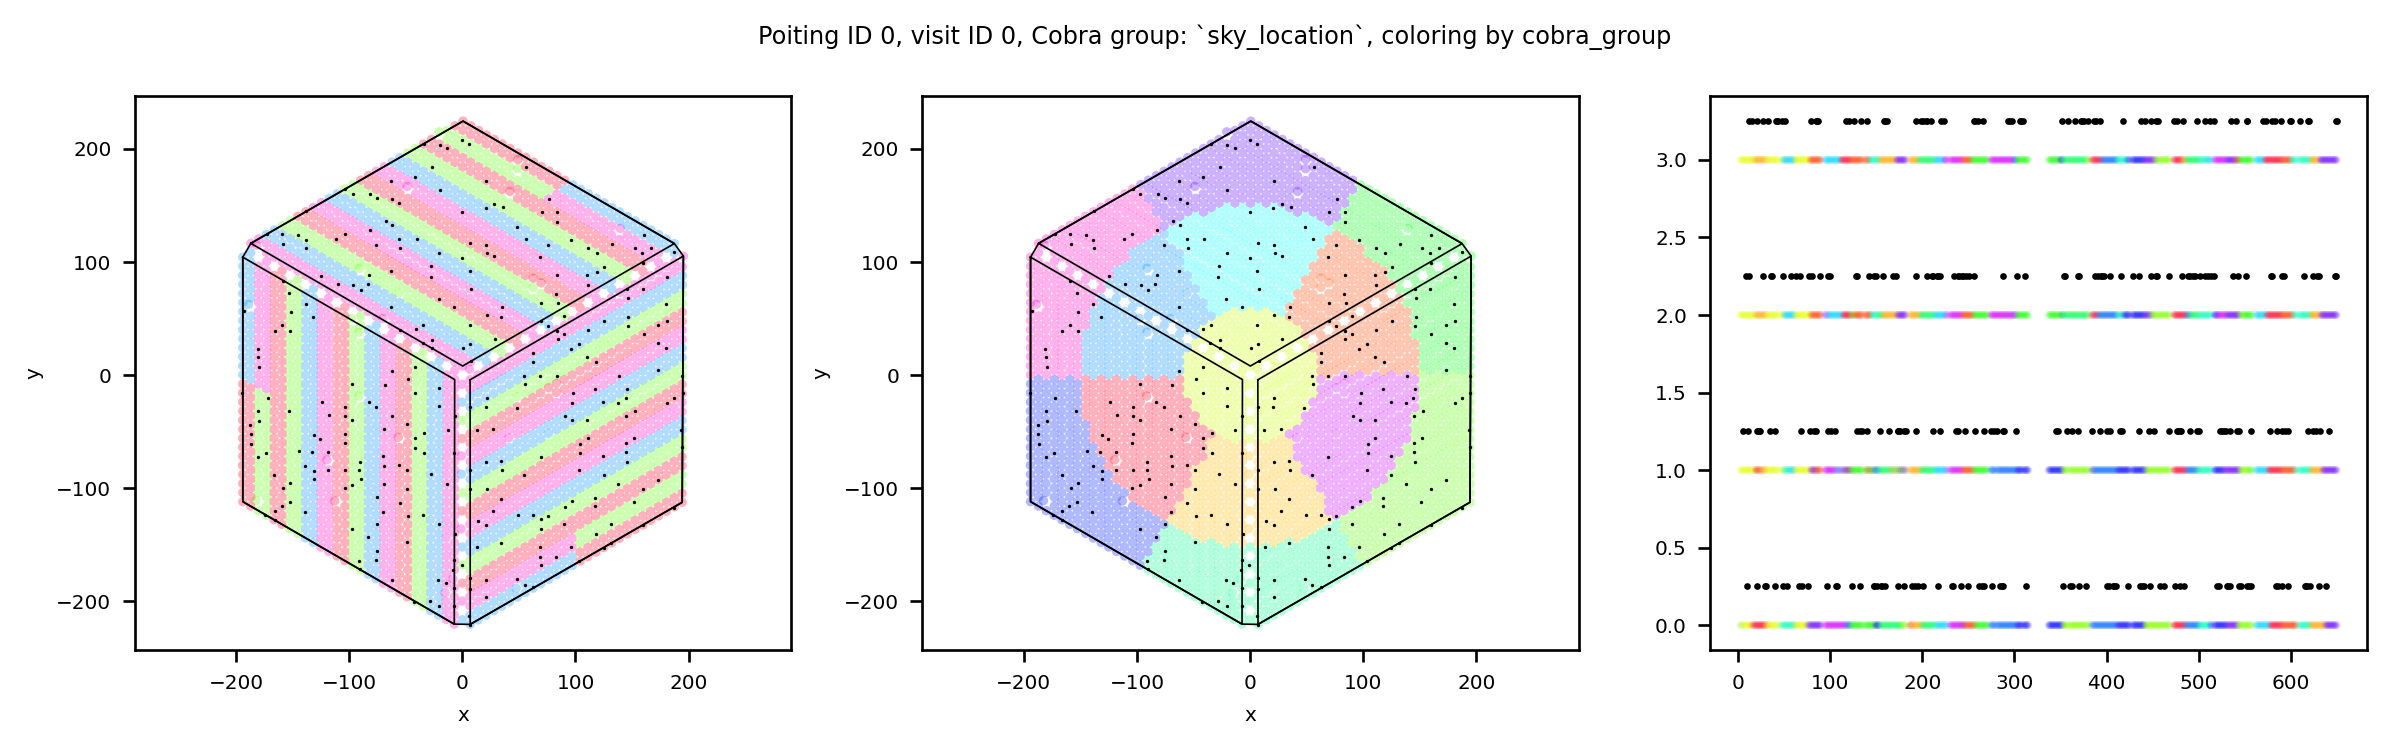

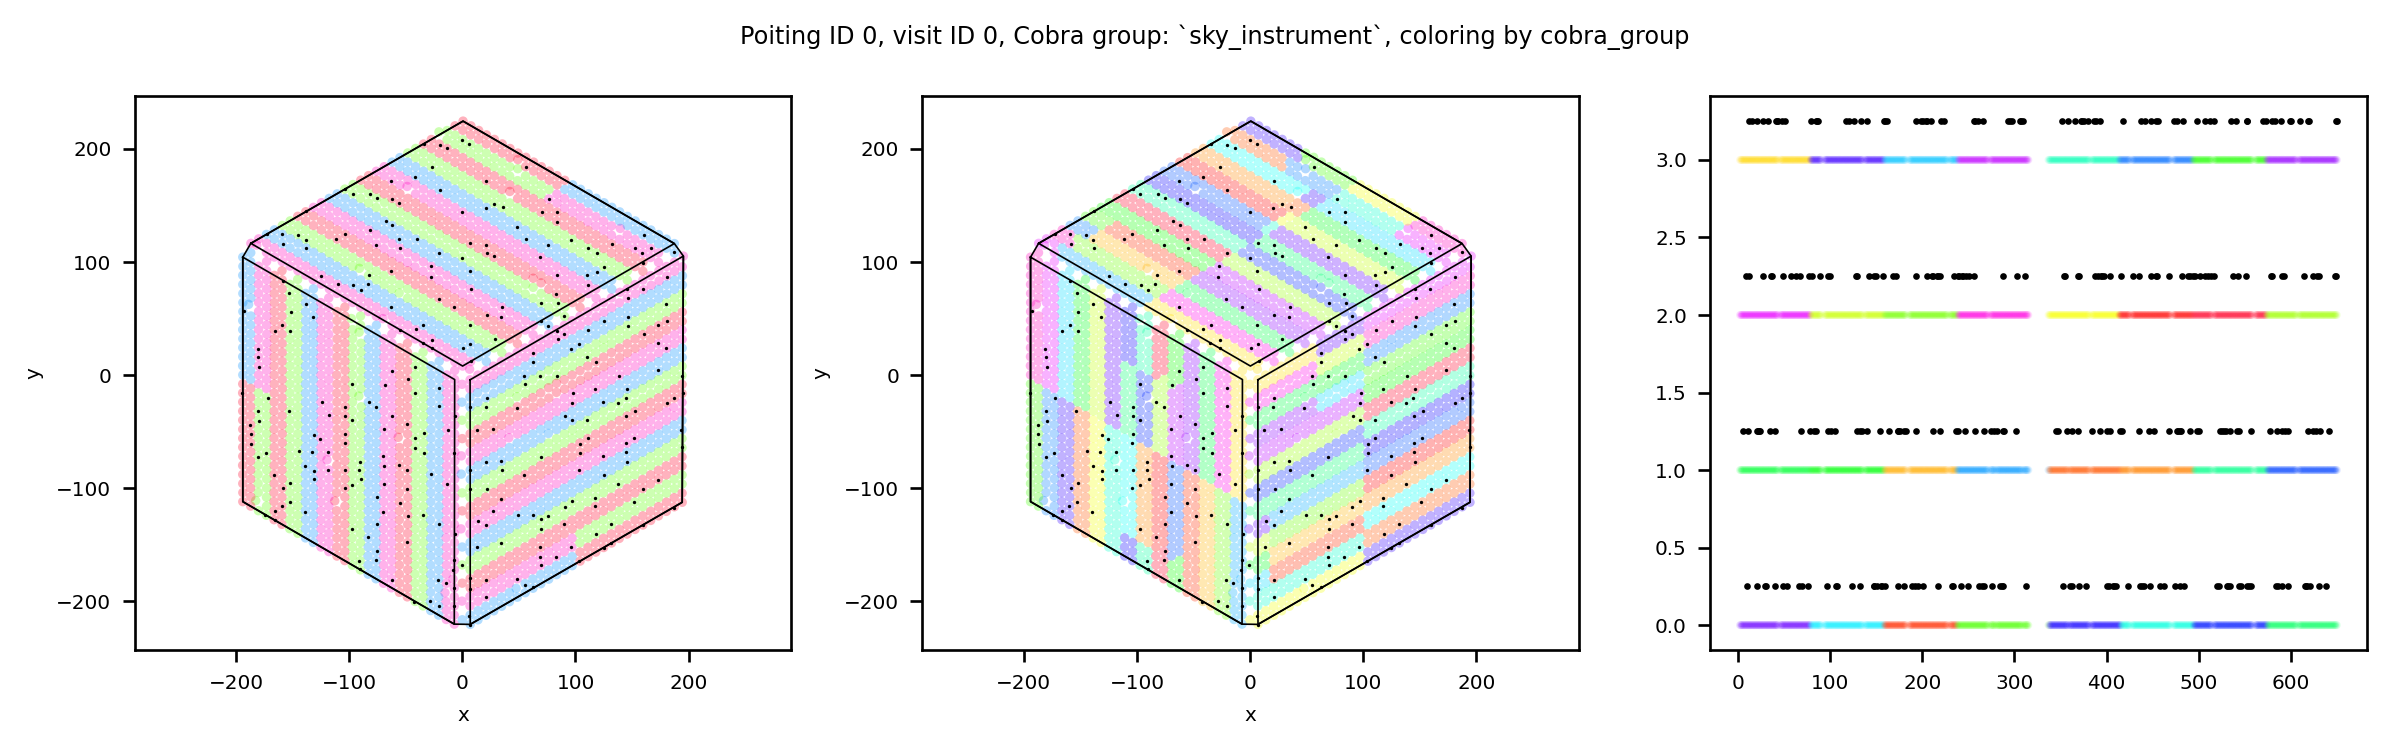

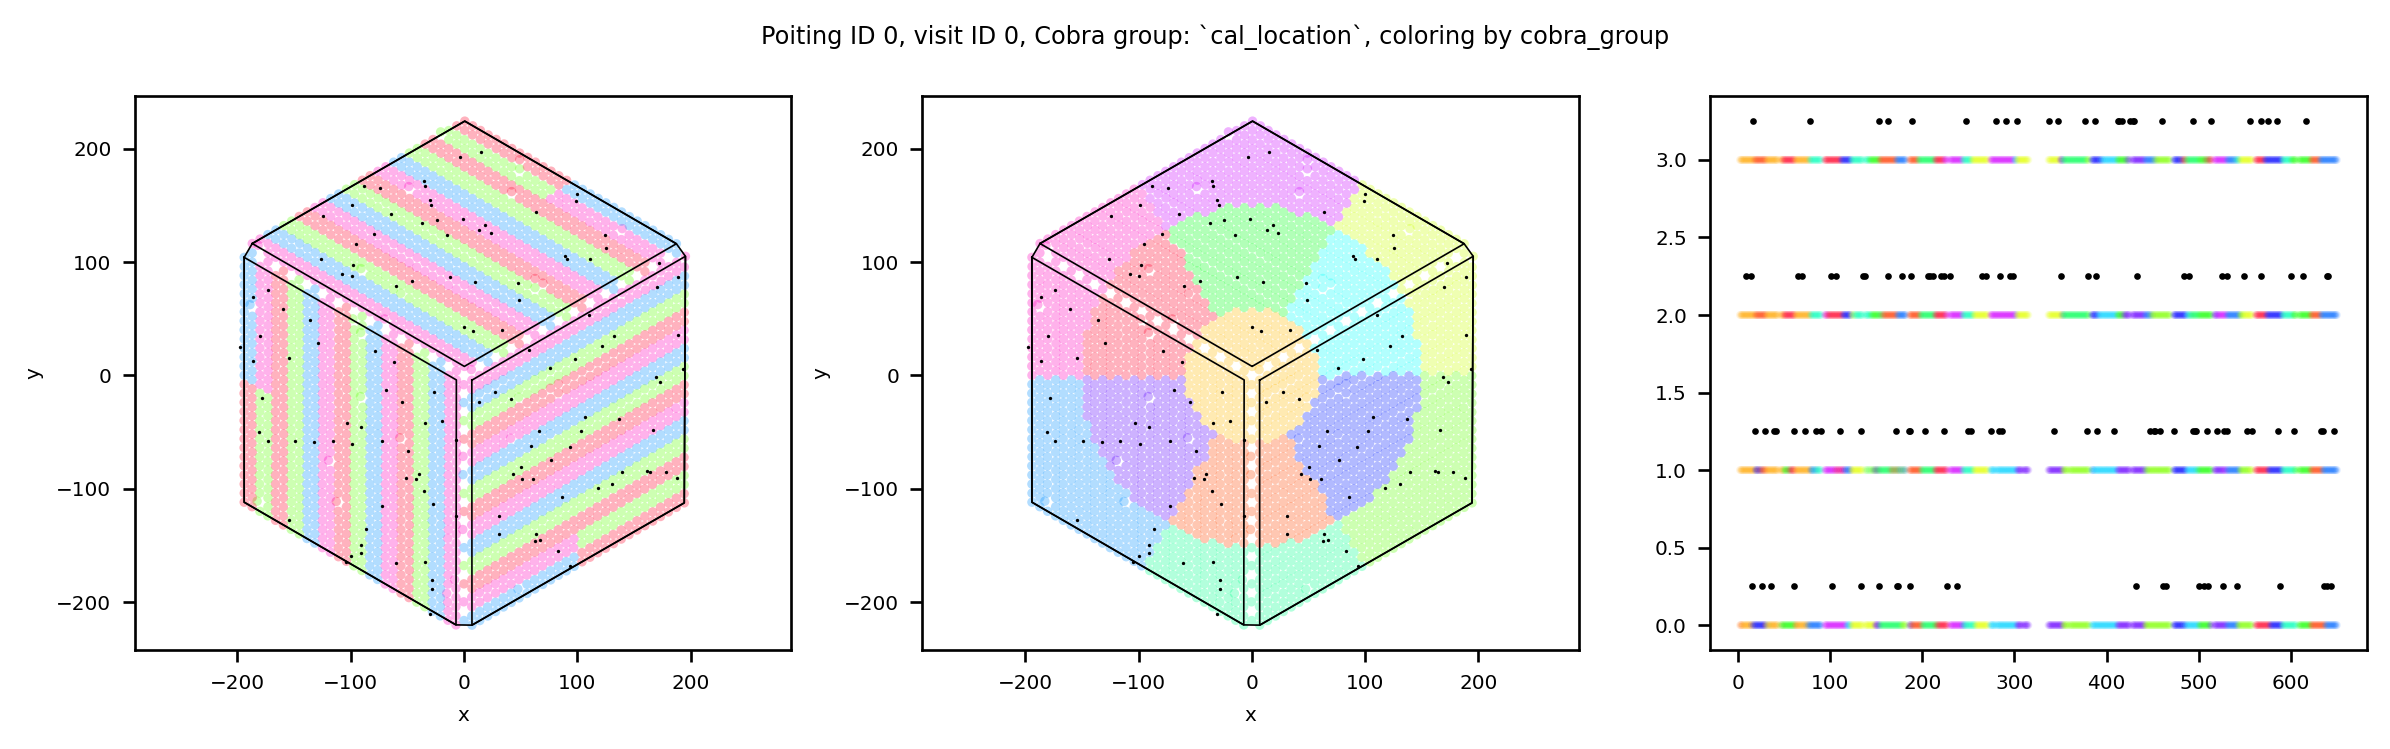

In [102]:
for cobra_group in config.netflow_options.cobra_groups.keys():
    for pidx in assignments['pointing_idx'].unique():

        pointing = config.pointings[pidx].get_pointing()

        for vidx in assignments[assignments['pointing_idx'] == pidx]['visit_idx'].unique():
            # print(p.ra, p.dec, p.posang)
            plot_instrument(pointing, pidx, vidx, cobra_group)